In [1]:
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math
from IPython.display import display
from IPython.display import Markdown
from scipy import linalg
from scipy import sparse
import scipy.sparse.linalg

2-D Transient Heat transfer was solved by using backward finite difference in time
The code has been modified accordingly for given conditions


In [12]:
def remove_corner(TT):
    """take N x N array
    return (N-2 + N*(N-2) + N-2,1) array"""
    N = TT.shape[0]
    p1 = TT[0,1:N-1].reshape(-1,1)
    p2 = TT[1:N-1,:].reshape(-1,1)
    p3 = TT[N-1,1:N-1].reshape(-1,1)
    return(np.r_[p1,p2,p3])

def add_corner(TT):
    """reverse of remove_corner
    the value to be added at the corner is 0"""
    N = int((TT.shape[0]+4)**0.5)
    p1 = TT[:N-2]
    p2 = TT[N-2:N**2-4-(N-2)]
    p3 = TT[N**2-4-(N-2):]
    result = np.r_[[[0]],p1,[[0]],
                p2,[[0]],p3,[[0]]].reshape(N,N)
    return result

#def cal_heat_backward_2D():
#specify the number of points

def heat_2D_Backward(Nx = 30, Nt = 101):
    '''this is to solve a dimensionless problem only
    the space must be square'''
    Ny = Nx
    #initialize space and time grids
    x = np.linspace(0,1,Nx)
    y = np.linspace(0,1,Ny)
    t = np.linspace(0,5,Nt)
    #calculate dx and dt
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    dt = t[1]-t[0]
    #make empty output matrix (row = t, col = x)
    TT = np.empty([Nt,Nx,Ny])
    #specify the initial condition
    TT[0,:,:] = 0
    X,Y = np.meshgrid(x,y)
    IC = np.full((Nx,Nx),0.5)
    TT[0,:,:] = IC

    r = dt/dx**2
    #q in 2D is different than q in 1D
    q = 1+4*r
   #creating the matrix A (combined discretized eqs.)
    A_00 = np.eye(Nx-2,Nx-2)
    A_01 = np.c_[np.zeros([Nx-2,1]),np.eye(Nx-2,Nx-2,dtype = int)*-1,
                 np.zeros([Nx-2,1])]
    A_10 = A_01.T*r
    A_Nm1_N = A_10 #for A_{N-1,N}
    A_11_mid = [1] + [q for i in range(Nx-2)] +[-1]
    A_11_top = [-1] + [-r for i in range(Nx-2)]
    A_11_bot = [-r for i in range(Nx-2)] + [1]
    A_11 = sparse.diags([A_11_top, A_11_mid, A_11_bot], [1,0,-1])
    A_N_Nm1 = (A_01.astype(int)*-1).astype(float)
    A_NN = (A_00.astype(int)*-1).astype(float)
    A_12 = np.c_[np.zeros([Nx,1]),A_10,np.zeros([Nx,1])]
    A_11s = [A_11.todense() for i in range(Nx-2)]
    AA = scipy.linalg.block_diag(*A_11s)
    #creating the top part of the diagonal terms
    indptr = np.array(range(Nx-2))
    indices = np.array(range(1,Nx-2))
    data = np.array([A_12 for i in range(Nx-3)])
    A_12_top = np.array(sparse.bsr_matrix((data,indices,indptr),
                  shape=(Nx*(Nx-3),Nx*(Nx-2))).todense())

    fill_size = AA.shape[0]-A_12_top.shape[0]
    fill_arr = np.zeros((fill_size,AA.shape[1]))
    A_12_same_shape = np.r_[A_12_top,fill_arr]
    AA_top_bot = A_12_same_shape + AA + A_12_same_shape.T
    _A_ = scipy.linalg.block_diag(A_00,AA_top_bot,A_NN)
    #fill non-square matrix in
    _A_[0:Nx-2,Nx-2:2*Nx-2] = A_01
    _A_[Nx-2:2*Nx-2,0:Nx-2] = A_10
    _A_[Nx**2-4-(Nx-2):Nx**2-4,Nx**2-4-(2*Nx-2):Nx**2-4-(Nx-2)] = A_N_Nm1
    _A_[Nx**2-4-(2*Nx-2):Nx**2-4-(Nx-2),Nx**2-4-(Nx-2):Nx**2-4] = A_Nm1_N
    
    i1 = Nx**2-4-1-(Nx-2)
    _A_[i1,i1-1] = 0
    _A_[i1,i1] = 1

    j1 = Nx**2-4-1-(Nx-2) - Nx
    _A_[j1,j1-1] = 0
    _A_[j1,j1] = 1

    j2 = Nx**2-4-1-(Nx-2) - Nx - Nx
    _A_[j2,j2-1] = 0
    _A_[j2,j2] = 1

    j3 = Nx**2-4-1-(Nx-2) - Nx -Nx -Nx
    _A_[j3,j3-1] = 0
    _A_[j3,j3] = 1
    
# Heat sink is introduced below
#     c1= Nx**2-4-1-(Nx-2) +1
#     _A_[c1,:] = 0
#     _A_[c1,c1] = 1
    
#     c2=  Nx**2-4-1-(Nx-2) +2
#     _A_[c2,:] = 0
#     _A_[c2,c2] = 1
    
    b0_idx = np.array([[i*Nx,i*Nx+Nx-1] 
                for i in range(Nx-2)]).reshape(-1) + Nx-2
    b0_idx = np.r_[np.arange(Nx-2),b0_idx,np.arange(Nx-2)+Nx**2-4-Nx+2]
    _A_super = sparse.linalg.splu(sparse.csc_matrix(_A_))
    for j in range(1,Nt):
        _B_ = remove_corner(TT[j-1,:,:])
        _B_[b0_idx,0] = 0
        _B_[i1] = 1
        _B_[j1] = 1
        _B_[j2] = 1
        _B_[j3] = 1
        tslice_img = _A_super.solve(_B_)
        TT[j,:,:] = add_corner(tslice_img)
    return TT,dx,dy,dt,x,y,t
TT,dx,dy,dt,x,y,t = heat_2D_Backward()

In [13]:
xx_m2, yy_m2 = np.meshgrid(x,y)

In [14]:
xx_m_d2 = xx_m2 * 3
yy_m_d2 = yy_m2 * 3

Results are shown below

<IPython.core.display.Javascript object>


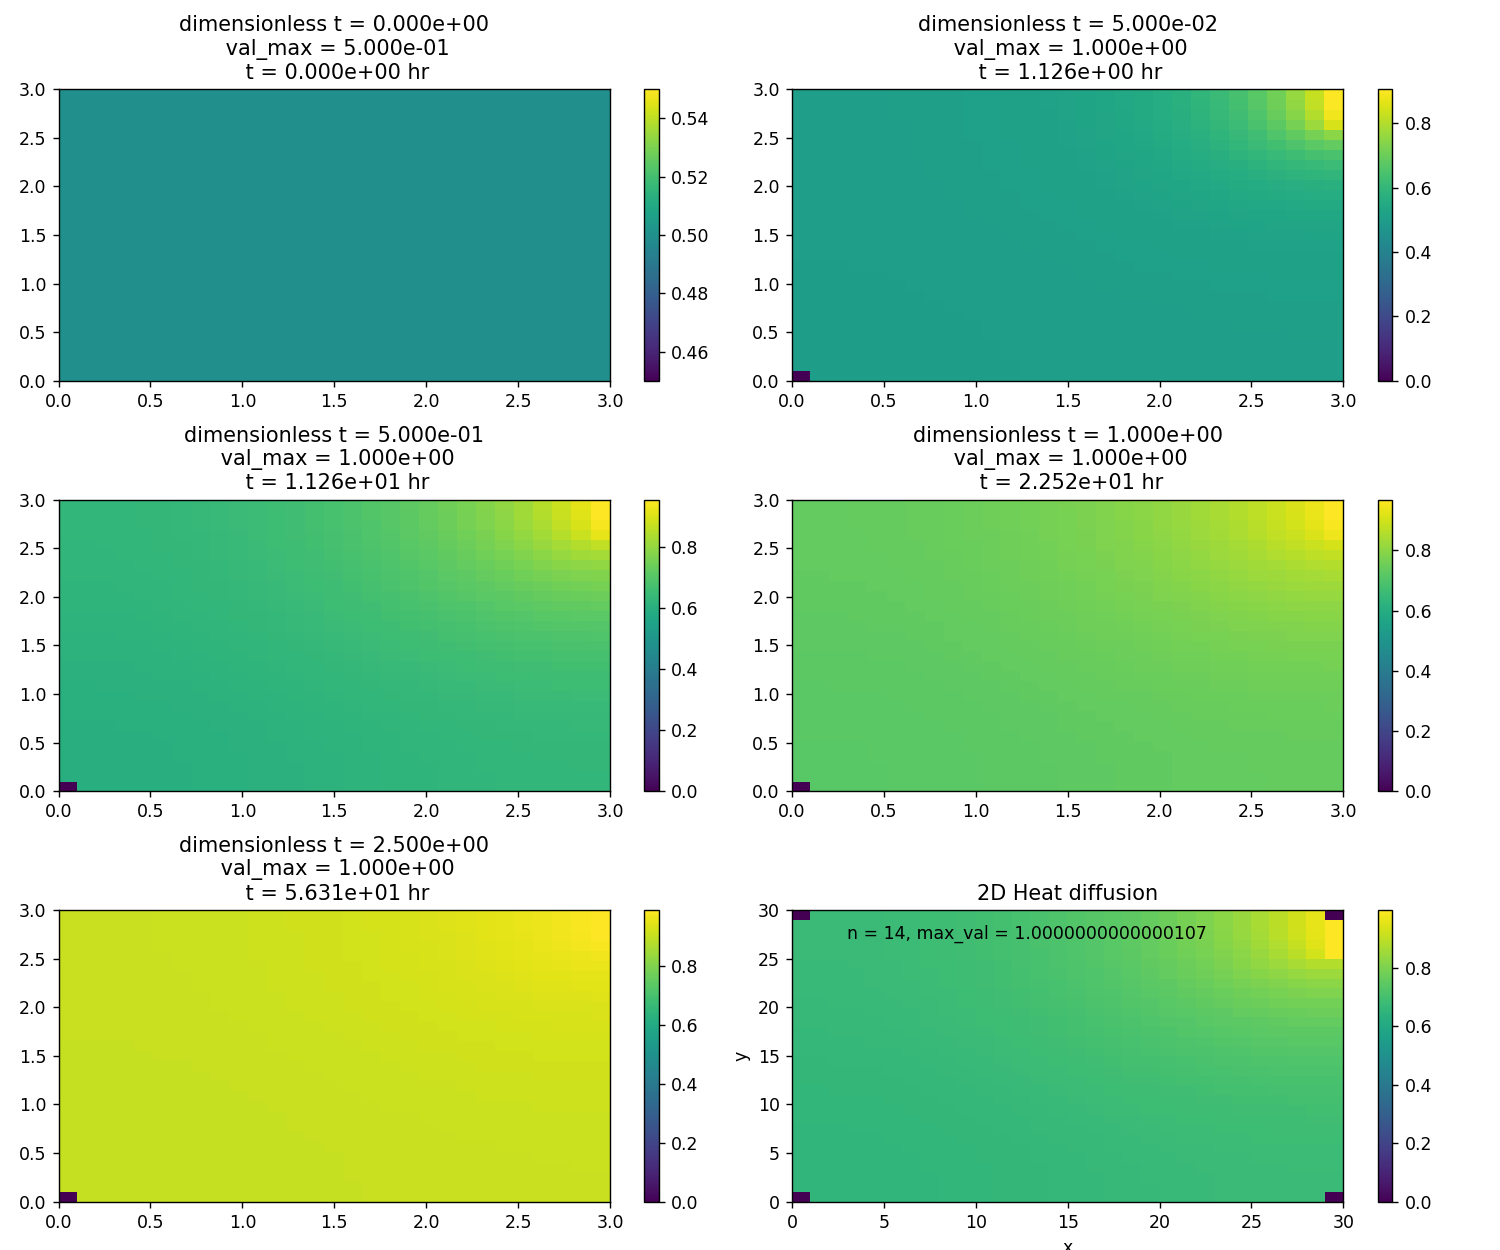

In [15]:
N=0
t_a= dt*N*9/(1.11e-4)
fig = plt.figure(figsize = (12,10))

plt.subplot(321)
plt.pcolor(xx_m_d2,yy_m_d2,TT[N,:,:])
plt.title('dimensionless t = {:.3e}\n val_max = {:.3e}\n t = {:.3e} hr'.format(
    dt*N,TT[N,:,:].max(),t_a/3600))
plt.colorbar()
plt.xlabel('\n')

N=1
t_a= dt*N*9/(1.11e-4)
plt.subplot(322)
plt.pcolor(xx_m_d2,yy_m_d2,TT[N,:,:])
plt.title('dimensionless t = {:.3e}\n val_max = {:.3e}\n t = {:.3e} hr'.format(
    dt*N,TT[N,:,:].max(),t_a/3600))
plt.colorbar()
plt.xlabel('\n')

N=10
t_a= dt*N*9/(1.11e-4)
plt.subplot(323)
plt.pcolor(xx_m_d2,yy_m_d2,TT[N,:,:])
plt.title('dimensionless t = {:.3e}\n val_max = {:.3e}\n t = {:.3e} hr'.format(
    dt*N,TT[N,:,:].max(),t_a/3600))
plt.colorbar()
plt.xlabel('\n')

N=20
t_a= dt*N*9/(1.11e-4)
plt.subplot(324)
plt.pcolor(xx_m_d2,yy_m_d2,TT[N,:,:])
plt.title('dimensionless t = {:.3e}\n val_max = {:.3e}\n t = {:.3e} hr'.format(
    dt*N,TT[N,:,:].max(),t_a/3600))
plt.colorbar()
plt.xlabel('\n')

N=50
t_a= dt*N*9/(1.11e-4)
plt.subplot(325)
plt.pcolor(xx_m_d2,yy_m_d2,TT[N,:,:])
plt.title('dimensionless t = {:.3e}\n val_max = {:.3e}\n t = {:.3e} hr'.format(
    dt*N,TT[N,:,:].max(),t_a/3600))
plt.colorbar()
plt.xlabel('\n')

N=100
t_a= dt*N*9/(1.11e-4)
plt.subplot(326)
plt.pcolor(xx_m_d2,yy_m_d2,TT[N,:,:])
plt.title('dimensionless t = {:.3e}\n val_max = {:.3e}\n t = {:.3e} hr'.format(
    dt*N,TT[N,:,:].max(),t_a/3600))
plt.colorbar()
plt.xlabel('\n')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


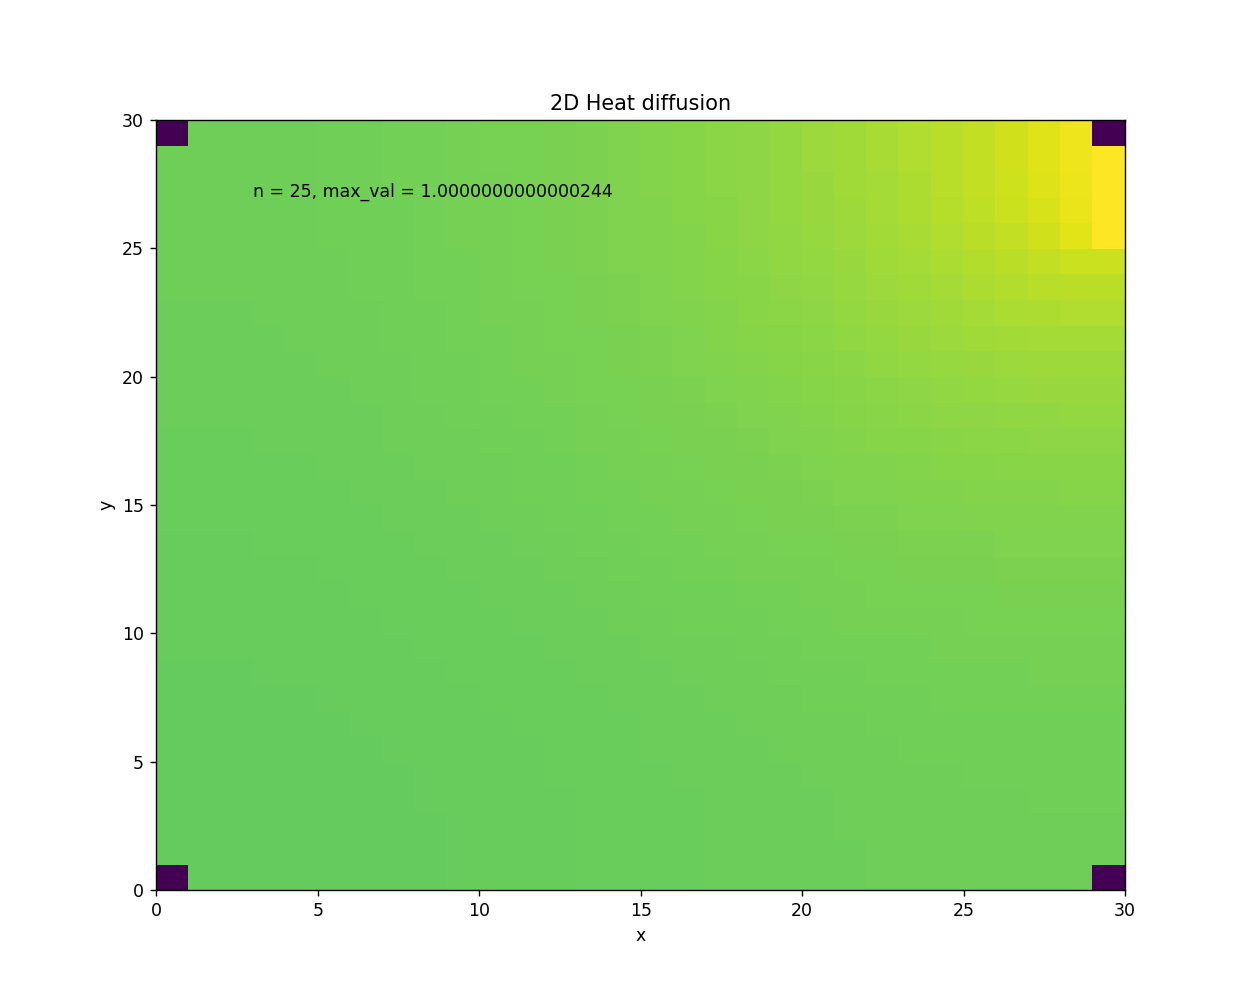

In [11]:
%matplotlib notebook
def update2(curr):
    #Code is modified from Christopher Brooks, University of Michigan
    #Python plotting, coursera
    plt.cla()
    im = plt.pcolor(TT[curr,:,:])
    plt.clim(0,1)
    vmax = np.max(TT[curr,:,:])
    vmin = np.min(TT[curr,:,:])
    plt.gca().set_title('2D Heat diffusion')
    plt.gca().set_ylabel('y')
    plt.gca().set_xlabel('x')
    plt.annotate('n = {}, max_val = {}'.format(curr,vmax), [3,27])
    im.set_clim(vmin,vmax)
fig = plt.figure(figsize=(10,8))
plt.pcolor(TT[0,:,:])
a2 = animation.FuncAnimation(fig, update2, interval=300, frames = 100)
a2.save('2D_Animation.mp4',fps=10, dpi=100)
plt.show()